# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets.

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English.

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text.

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np

In [3]:
!pip install tensorflow==2.10.0
!pip install keras==2.10.0

Let's get the data!

In [4]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [5]:
# Step 1: Initializing and fitting a tokenizer on the Shakespearean corpus

from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize tokenizer
tokenizer = Tokenizer()

# Fit tokenizer on the corpus
corpus = [
    "Shall I compare thee to a summer's day?",
    "Thou art more lovely and more temperate:",
    "Rough winds do shake the darling buds of May,",
    "And summer's lease hath all too short a date:",
    "Sometime too hot the eye of heaven shines,",
    "And often is his gold complexion dimm'd;",
    "And every fair from fair sometime declines,",
    "By chance or nature's changing course untrimm'd;",
    "But thy eternal summer shall not fade",
    "Nor lose possession of that fair thou owest;",
    "Nor shall death brag thou wanderest in his shade,",
    "When in eternal lines to time thou growest:",
    "So long as men can breathe or eyes can see,",
    "So long lives this, and this gives life to thee."
]
# Fitting tokenizer
tokenizer.fit_on_texts(corpus)



Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [6]:
total_words = len(tokenizer.word_index) + 1  # Adding 1 to include padding

# Display vocabulary size for confirmation
total_words

84

Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [7]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [8]:
# Your code here :

Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
label = np.array(label)
label


array([23, 24,  7,  4,  8,  9, 25, 26, 10, 27,  1, 10, 28, 30, 31, 32, 11,
       33, 34,  5, 35,  9, 36, 37, 38, 12, 39,  8, 40, 12, 41, 11, 42,  5,
       43, 44, 45, 46, 14, 47, 48, 49, 50,  6, 51,  6, 13, 52, 54, 15, 55,
       56, 57, 58, 60, 16, 61,  3, 62, 63, 64, 65,  5, 66,  6,  2, 67,  3,
       68, 69,  2, 70, 18, 14, 71, 18, 16, 73,  4, 74,  2, 75, 20, 76, 77,
       21, 78, 15, 79, 21, 80, 20, 81, 22,  1, 22, 82, 83,  4,  7],
      dtype=int32)

In [12]:
# Shift the labels to start from 0 by subtracting 1
label = label - 1

# Find the maximum value in 'label'
max_label_value = np.max(label)

# Initialize num_classes before using it in the 'max' function
num_classes = 0  # or any other initial value suitable for your task

# Adjust num_classes if necessary
num_classes = max(num_classes, max_label_value + 1)
num_classes


81

One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors.

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [36]:
import numpy as np
from tensorflow import keras
# Convert 'label' to one-hot encoded format
#label = label.reshape(-1)  # Flatten the array
#num_classes = 84
#label = keras.utils.to_categorical(label, num_classes=num_classes)

In [37]:
if label.dtype != np.int64:  # or np.int32 if your indices are 32-bit
    label = label.astype(int)  # Convert to integer type

# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [38]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten # Import Flatten

model = Sequential([
    Embedding(total_words, 64, input_length=max_sequence_len-1),
    LSTM(100),
    Dense(total_words, activation='softmax')
])
model.add(Flatten()) # Now Flatten is recognized

# Add a Dense layer with 84 neurons and softmax activation
model.add(Dense(84, activation='softmax'))

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [39]:
model.compile(loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=0.01),
            metrics=['accuracy'])

# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 9, 64)             5376      
                                                                 
 lstm_3 (LSTM)               (None, 100)               66000     
                                                                 
 dense_5 (Dense)             (None, 84)                8484      
                                                                 
 flatten_2 (Flatten)         (None, 84)                0         
                                                                 
 dense_6 (Dense)             (None, 84)                7140      
                                                                 
Total params: 87,000
Trainable params: 87,000
Non-trainable params: 0
_________________________________________________________________


# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [41]:
history = model.fit(predictors, label, epochs=50, verbose=1)

Epoch 1/50
4/4 [==============================] - 2s 9ms/step - loss: 4.4012 - accuracy: 0.3500
Epoch 2/50
4/4 [==============================] - 0s 8ms/step - loss: 4.1246 - accuracy: 0.9800
Epoch 3/50
4/4 [==============================] - 0s 8ms/step - loss: 3.9304 - accuracy: 0.9800
Epoch 4/50
4/4 [==============================] - 0s 8ms/step - loss: 3.7611 - accuracy: 0.9800
Epoch 5/50
4/4 [==============================] - 0s 7ms/step - loss: 3.6017 - accuracy: 0.9800
Epoch 6/50
4/4 [==============================] - 0s 7ms/step - loss: 3.4407 - accuracy: 0.9800
Epoch 7/50
4/4 [==============================] - 0s 8ms/step - loss: 3.2817 - accuracy: 0.9800
Epoch 8/50
4/4 [==============================] - 0s 7ms/step - loss: 3.1156 - accuracy: 0.9800
Epoch 9/50
4/4 [==============================] - 0s 8ms/step - loss: 2.9473 - accuracy: 0.9800
Epoch 10/50
4/4 [==============================] - 0s 7ms/step - loss: 2.7788 - accuracy: 0.9800
Epoch 11/50
4/4 [======================

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

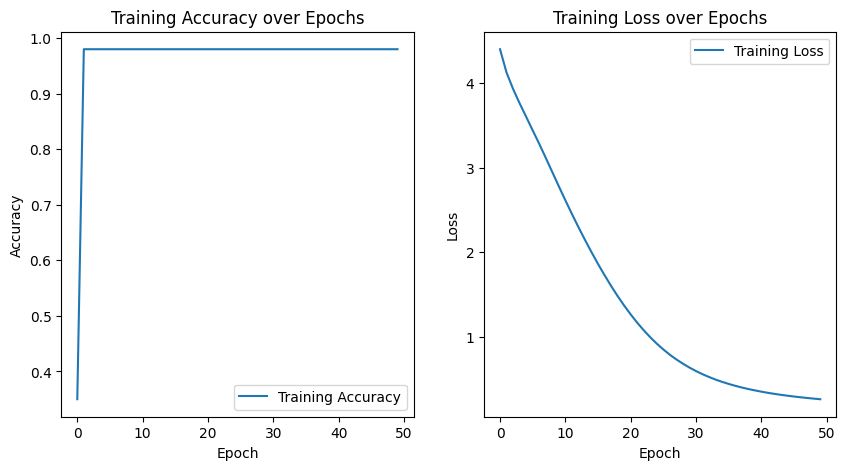

In [42]:
!pip install matplotlib

import matplotlib.pyplot as plt

# Get training accuracy and loss values from the history object
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']

# Create the plot for accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Create the plot for loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [44]:
seed_text = "Write the text you want the model to use as a starting point to generate the next words"
next_words = 50  # Generate 50 words after the seed text

Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [49]:
import numpy as np # Import numpy for array operations


def generate_text(seed_text, next_words, model, tokenizer):
    for _ in range(next_words):
        # Tokenize the seed text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # Pad the token_list to have the expected sequence length (9 in this case)
        token_list = np.pad(token_list, (0, 9 - len(token_list)), 'constant')

        # Reshape the token_list to have the expected 2D shape
        token_list = np.reshape(token_list, (1, 9)) # Reshape to (1, sequence_length)

        # Predict the next word
        predicted_probs = model.predict(token_list)
        predicted_id = np.argmax(predicted_probs, axis=-1)

        # Get the actual word from the predicted ID
        # Check if the predicted ID is in the tokenizer's vocabulary
        # If not present, use a default word or handle the unknown token
        output_word = tokenizer.index_word.get(predicted_id[0], '<UNK>')

        # Append the predicted word to the seed text
        seed_text += " " + output_word
    return seed_text

# Generate and print the text
generated_text = generate_text(seed_text, next_words, model, tokenizer)  # Assume tokenizer is defined
print(generated_text)

1/1 [==============================] - 0s 19ms/step
Write the text you want the model to use as a starting point to generate the next words <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


Experiment with at least 3 different seed_text strings and see what happens!

In [50]:
import numpy as np

def generate_text(seed_text, next_words, model, tokenizer):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = np.pad(token_list, (0, 9 - len(token_list)), 'constant')
        token_list = np.reshape(token_list, (1, 9))
        predicted_probs = model.predict(token_list)
        predicted_id = np.argmax(predicted_probs, axis=-1)
        output_word = tokenizer.index_word.get(predicted_id[0], '<UNK>')
        seed_text += " " + output_word
    return seed_text

# Different seed texts to try
seed_texts = [
    "The quick brown fox jumps over the",
    "Once upon a time there was a",
    "In a galaxy far far away",
    "Hello, how are you doing"
]

# Generate and print text for each seed text
for seed_text in seed_texts:
    next_words = 50
    generated_text = generate_text(seed_text, next_words, model, tokenizer)
    print(f"Seed Text: {seed_text}\nGenerated Text: {generated_text}\n\n")

1/1 [==============================] - 0s 22ms/step
Seed Text: The quick brown fox jumps over the
Generated Text: The quick brown fox jumps over the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


1/1 [==============================] - 0s 19ms/step
Seed Text: Once upon a time there was a
Generated Text: Once upon a time there was a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


1/1 [==============================] - 0s 20ms/step
Seed Text: In a galaxy far far away
Generated Text: In a g